In [ ]:
from google.colab import files
uploaded = files.upload()

Saving nifty50.csv to nifty50.csv


In [ ]:
import pandas as pd
import io
df = pd.read_csv(io.BytesIO(uploaded['nifty50.csv']), index_col='Date', parse_dates=True)
df = df.dropna()
# print('Shape of data', df.shape)
df

# CONST VALUE
steps = 150

In [ ]:
df1=df.reset_index()['Close']
df1

0        8395.450195
1        8378.400391
2        8127.350098
3        8102.100098
4        8234.599609
            ...     
1560    14923.150391
1561    15108.099609
1562    15030.150391
1563    14906.049805
1564    15175.299805
Name: Close, Length: 1565, dtype: float64

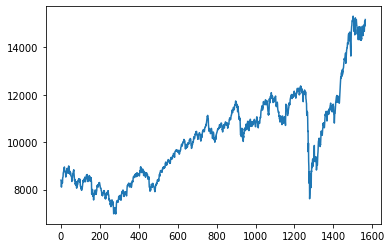

In [ ]:
import matplotlib.pyplot as plt
plt.plot(df1)

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))
df1.shape

(1565, 1)

In [ ]:
training_size=int(len(df1)*0.75)
test_size=int(len(df1)*.15)
dataset_length = training_size+test_size
train_data,test_data=df1[0:training_size],df1[training_size:dataset_length]
training_size, test_size

(1173, 234)

In [ ]:
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   # i=0 => 0,1,2,3-----99   150 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [ ]:
time_step = 150
x_train, y_train = create_dataset(train_data, time_step)
x_test, y_test = create_dataset(test_data, time_step)
print(x_train.shape), print(y_train.shape)

(1022, 150)
(1022,)


(None, None)

In [ ]:
print(x_test.shape), print(y_test.shape)

(83, 150)
(83,)


(None, None)

In [ ]:
import tensorflow as tf
# reshape input to be [samples, time steps, features] which is required for LSTM
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

In [ ]:
# Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(steps,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 150, 50)           10400     
_________________________________________________________________
lstm_4 (LSTM)                (None, 150, 50)           20200     
_________________________________________________________________
lstm_5 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Lets Do the prediction and check performance metrics
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

In [ ]:
model.fit(x_train,y_train,validation_data = (x_test,y_test), epochs = 100, batch_size = 64,verbose = 1)

Epoch 1/100
16/16 [==============================] - 11s 360ms/step - loss: 0.0452 - val_loss: 0.0143
Epoch 2/100
16/16 [==============================] - 4s 262ms/step - loss: 0.0041 - val_loss: 0.0060
Epoch 3/100
16/16 [==============================] - 4s 256ms/step - loss: 0.0014 - val_loss: 0.0041
Epoch 4/100
16/16 [==============================] - 4s 262ms/step - loss: 0.0011 - val_loss: 0.0020
Epoch 5/100
16/16 [==============================] - 4s 268ms/step - loss: 7.9873e-04 - val_loss: 0.0020
Epoch 6/100
16/16 [==============================] - 4s 260ms/step - loss: 7.9331e-04 - val_loss: 0.0019
Epoch 7/100
16/16 [==============================] - 4s 258ms/step - loss: 7.5427e-04 - val_loss: 0.0017
Epoch 8/100
16/16 [==============================] - 4s 270ms/step - loss: 7.7054e-04 - val_loss: 0.0022
Epoch 9/100
16/16 [==============================] - 4s 258ms/step - loss: 7.6013e-04 - val_loss: 0.0016
Epoch 10/100
16/16 [==============================] - 4s 261ms/step - 

In [ ]:
model.save('nifty_model.h5')

In [ ]:
# Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [ ]:
# Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

9849.155721837822

In [ ]:
# Test Data RMSE
math.sqrt(mean_squared_error(y_test,test_predict))

10979.407580675288

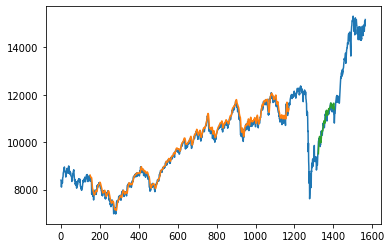

In [ ]:
# Plotting 
from matplotlib import pyplot as plt
# shift train predictions for plotting
look_back = steps
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
# testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
testPredictPlot[len(train_predict)+(look_back*2)+1:dataset_length-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [ ]:
x_input=test_data[len(test_data)-steps:].reshape(1,-1)
x_input.shape

(1, 150)

In [ ]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [ ]:
# demonstrate prediction for next 30 days
from numpy import array

nod=21
lst_output=[]
n_steps=150
i=0
while(i<nod):
    
    if(len(temp_input)>150):
        x_input=np.array(temp_input[1:])
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1
    
# print(lst_output)

In [ ]:
day_new=np.arange(1,151)
day_pred=np.arange(151,151+nod)

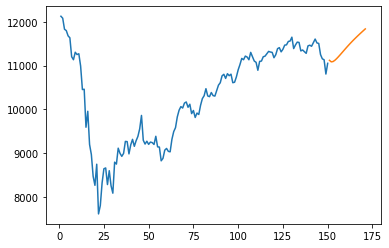

In [ ]:
plt.plot(day_new,scaler.inverse_transform(df1[dataset_length-150:dataset_length]).flatten())
plt.plot(day_pred,scaler.inverse_transform(lst_output))

In [ ]:
df3=df1[800:dataset_length].tolist()
df3.extend(lst_output)
df3=scaler.inverse_transform(df3).tolist()
df4=df1[800:dataset_length+20]
df4=scaler.inverse_transform(df4)

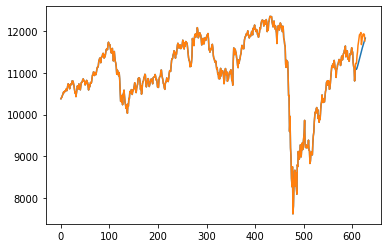

In [ ]:
plt.plot(df3)
plt.plot(df4)